# Explanation of Models Prediction Using  Grad-CAM

To understand the prediction of the deep learning models on the datasets, the use of  `Grad-CAM` provide useful and different ways of visualizing it. Below is a references to the github repo of the library:

[Grad-CAM Implementation in Pytorch](https://github.com/jacobgil/pytorch-grad-cam)

### Requirements
- When running this script, it is important that it is stored in the `pytorch-retinanet` folder that is the parent folder of the scripts. The source code is available for all the utilities that are used so if you want to recreate the model in another environment, you can freely do so.

## Implementation on RetinaNet

In [1]:
#Libraries and utils from train.py and coco_validation.py

# train.py
import collections

import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms

from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer
from torch.utils.data import DataLoader

from retinanet import coco_eval
from retinanet import csv_eval
import os

# coco_validation.py
import argparse
import torch
from torchvision import transforms

from retinanet import model
from retinanet.dataloader import CocoDataset, Resizer, Normalizer
from retinanet import coco_eval
import gc

print('CUDA available: {}'.format(torch.cuda.is_available()))
torch.cuda.manual_seed(5000)
gc.collect()

CUDA available: False


/home/toni11/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


52

Loading model...
Model loaded successfully on device: cpu

Debugging model structure...
Model structure:
conv1: Conv2d
bn1: BatchNorm2d
relu: ReLU
maxpool: MaxPool2d
layer1: Sequential
  layer1.0: Bottleneck
    layer1.0.conv1: Conv2d
    layer1.0.bn1: BatchNorm2d
    layer1.0.conv2: Conv2d
    layer1.0.bn2: BatchNorm2d
    layer1.0.conv3: Conv2d
    layer1.0.bn3: BatchNorm2d
    layer1.0.relu: ReLU
    layer1.0.downsample: Sequential
  layer1.1: Bottleneck
    layer1.1.conv1: Conv2d
    layer1.1.bn1: BatchNorm2d
    layer1.1.conv2: Conv2d
    layer1.1.bn2: BatchNorm2d
    layer1.1.conv3: Conv2d
    layer1.1.bn3: BatchNorm2d
    layer1.1.relu: ReLU
  layer1.2: Bottleneck
    layer1.2.conv1: Conv2d
    layer1.2.bn1: BatchNorm2d
    layer1.2.conv2: Conv2d
    layer1.2.bn2: BatchNorm2d
    layer1.2.conv3: Conv2d
    layer1.2.bn3: BatchNorm2d
    layer1.2.relu: ReLU
layer2: Sequential
  layer2.0: Bottleneck
    layer2.0.conv1: Conv2d
    layer2.0.bn1: BatchNorm2d
    layer2.0.conv2: Conv2d

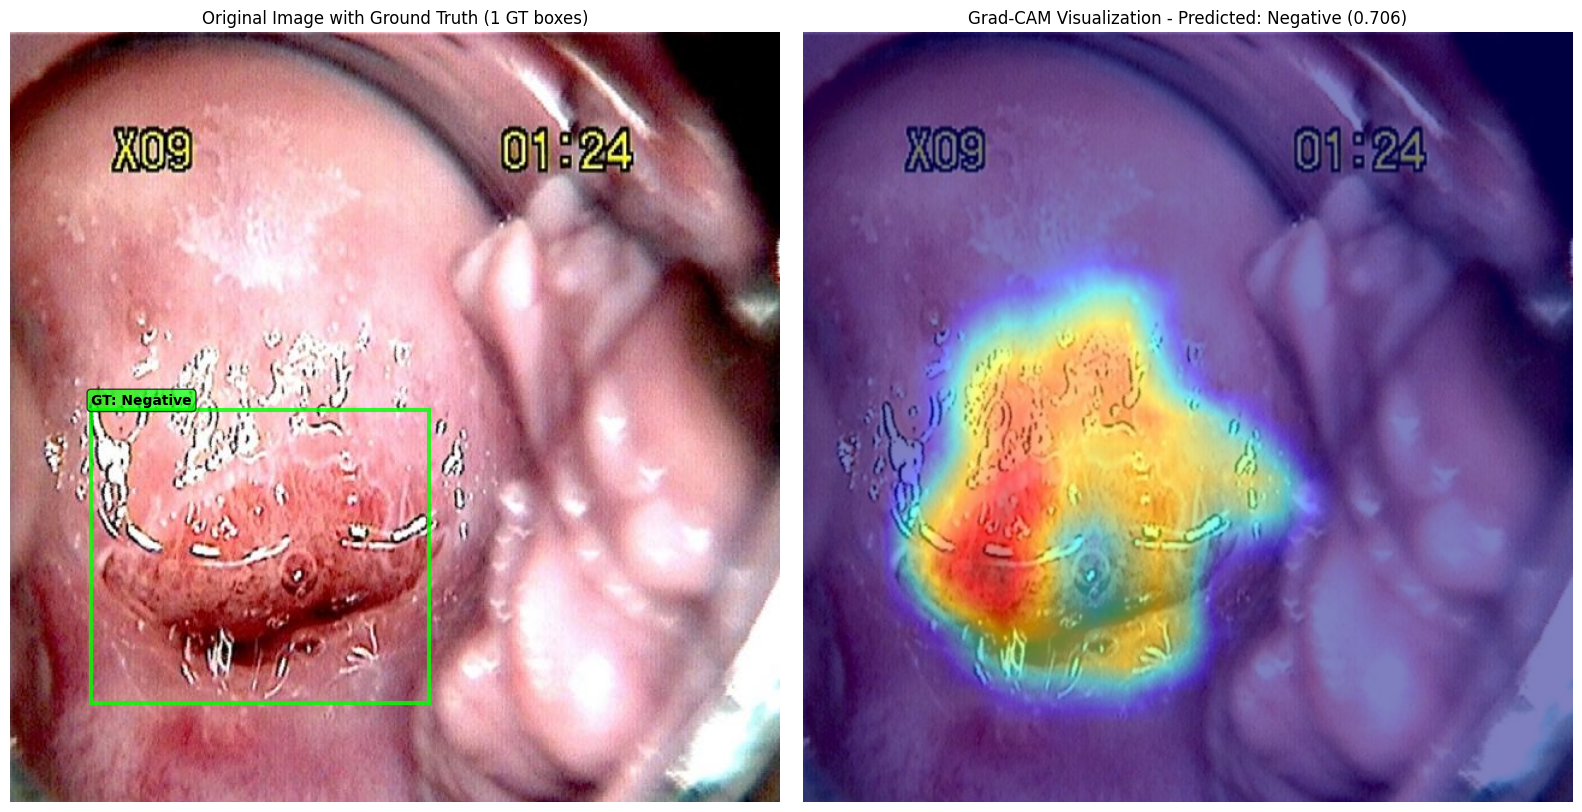


--- Detection Summary ---
Ground Truth: 1 objects
  GT 1: Negative
Prediction: Negative
Confidence: 0.706
Predicted Box: 2
--- End Summary ---

Successfully processed image 1/3

Attempt 2: Processing AAIA2_jpg.rf.b923dded303c8361d16282e8818c492d.jpg
Found 1 ground truth annotations
  GT 1: Positive at [58, 188, 553, 590]
Generating CAM visualization...
Model output type: <class 'list'>
Number of outputs: 3
Output 0 shape: torch.Size([11])
Output 1 shape: torch.Size([11])
Output 2 shape: torch.Size([11, 4])
Classifications shape: torch.Size([11])
Regressions shape: torch.Size([11])
Max probs shape: torch.Size([11])
Class indices shape: torch.Size([11])
Max probability: 0.7113
Using predicted class: 0, confidence: 0.711
Model output type: <class 'list'>
Number of outputs: 3
Output 0 shape: torch.Size([11])
Output 1 shape: torch.Size([11])
Output 2 shape: torch.Size([11, 4])
Classifications shape: torch.Size([11])
Regressions shape: torch.Size([11])
Max probs shape: torch.Size([11])
Clas

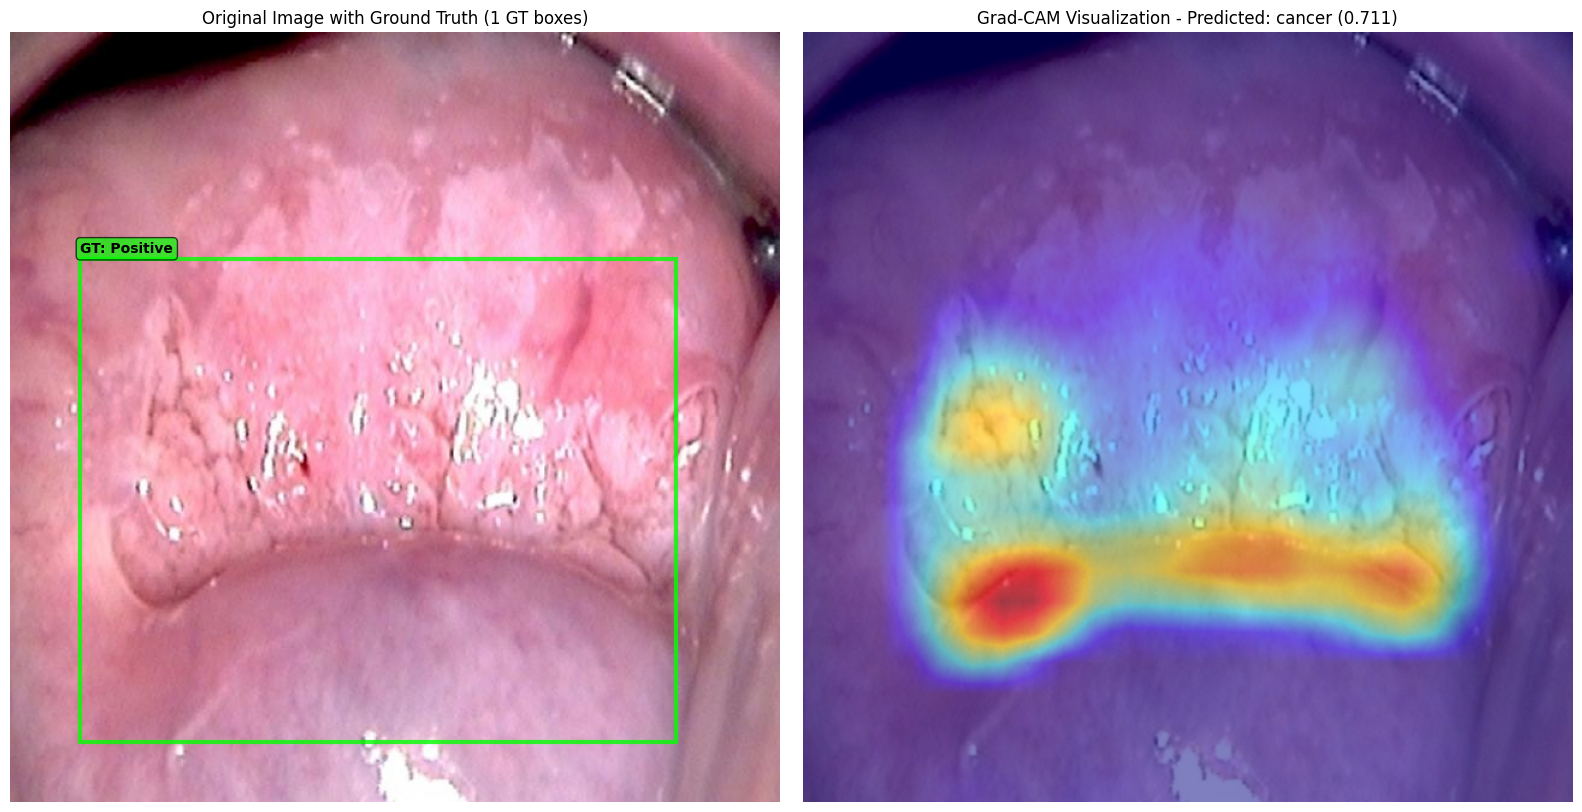


--- Detection Summary ---
Ground Truth: 1 objects
  GT 1: Positive
Prediction: cancer
Confidence: 0.711
Predicted Box: 1
--- End Summary ---

Successfully processed image 2/3

Attempt 3: Processing ACC1_jpg.rf.09aa495103ab7bdf243f6b32fb065d67.jpg
Found 1 ground truth annotations
  GT 1: Positive at [232, 101, 466.5, 410]
Generating CAM visualization...
Model output type: <class 'list'>
Number of outputs: 3
Output 0 shape: torch.Size([3])
Output 1 shape: torch.Size([3])
Output 2 shape: torch.Size([3, 4])
Classifications shape: torch.Size([3])
Regressions shape: torch.Size([3])
Max probs shape: torch.Size([3])
Class indices shape: torch.Size([3])
Max probability: 0.7066
Using predicted class: 0, confidence: 0.707
Model output type: <class 'list'>
Number of outputs: 3
Output 0 shape: torch.Size([3])
Output 1 shape: torch.Size([3])
Output 2 shape: torch.Size([3, 4])
Classifications shape: torch.Size([3])
Regressions shape: torch.Size([3])
Max probs shape: torch.Size([3])
Class indices sha

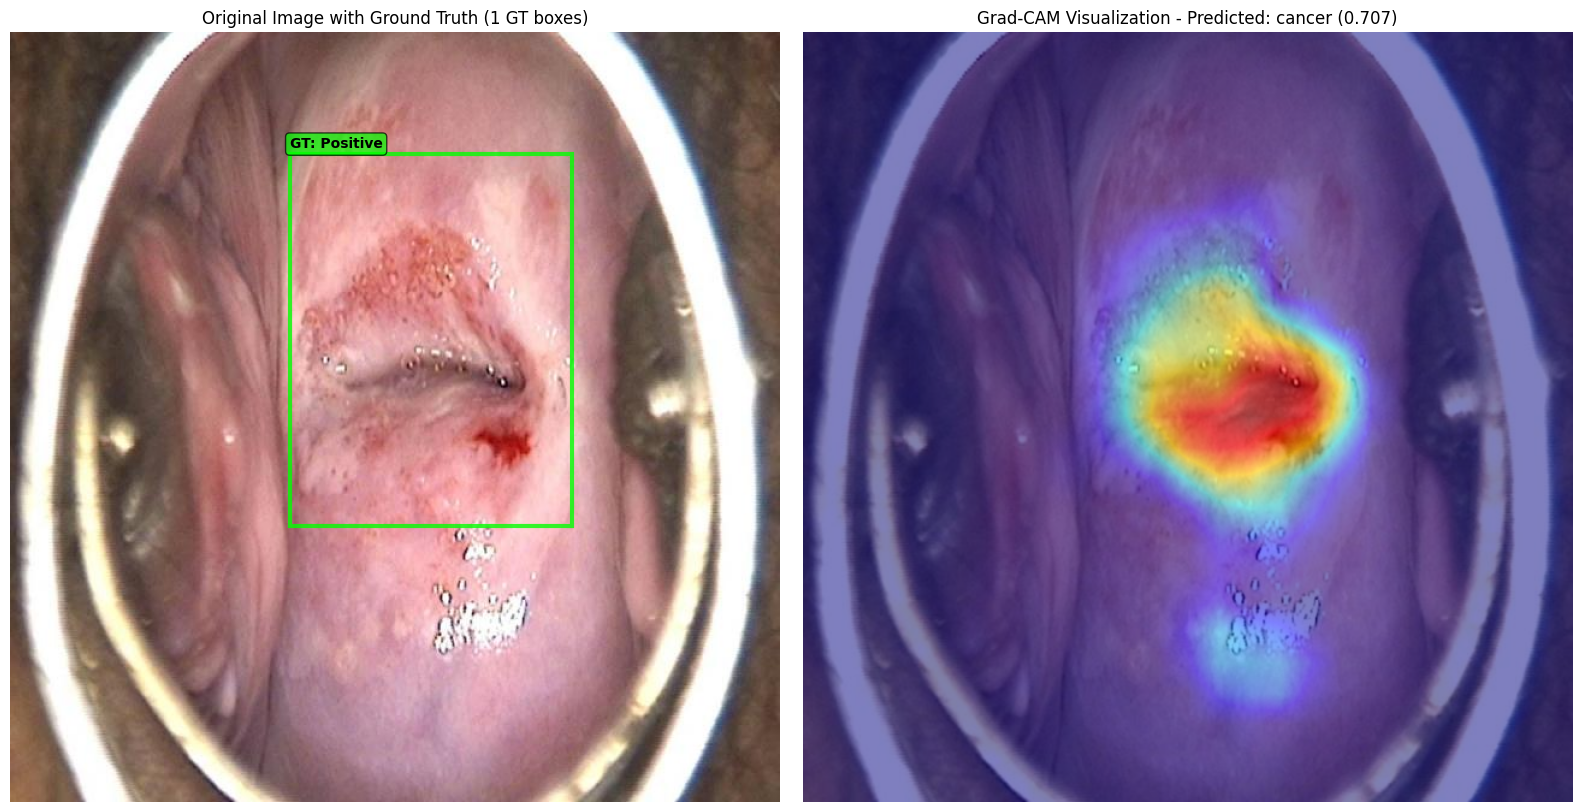


--- Detection Summary ---
Ground Truth: 1 objects
  GT 1: Positive
Prediction: cancer
Confidence: 0.707
Predicted Box: 1
--- End Summary ---

Successfully processed image 3/3

Completed: 3/3 images processed successfully


In [3]:
import os
import json
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

# pytorch_grad_cam imports
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, HiResCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


def load_coco_annotations(annotation_file):
    """Load COCO format annotations"""
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)
    
    # Create mappings
    images = {img['id']: img for img in coco_data['images']}
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Group annotations by image
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)
    
    return images, categories, annotations_by_image


def load_and_preprocess_image(image_path, target_size=800):
    """Load and preprocess image for RetinaNet"""
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Keep original image as numpy array for visualization
    original_np = np.array(image)
    
    # Resize while maintaining aspect ratio
    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Also create normalized RGB image for CAM visualization
    rgb_transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor(),
    ])
    
    tensor_image = transform(image)
    rgb_image = rgb_transform(image).permute(1, 2, 0).numpy()
    
    return tensor_image, rgb_image, original_np, original_size


def get_model_predictions(model, input_tensor, confidence_threshold=0.5):
    """Get model predictions with confidence filtering - Fixed version"""
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor.unsqueeze(0))
    
    print(f"Model output type: {type(outputs)}")
    if isinstance(outputs, (list, tuple)):
        print(f"Number of outputs: {len(outputs)}")
        for i, output in enumerate(outputs):
            if isinstance(output, torch.Tensor):
                print(f"Output {i} shape: {output.shape}")
            else:
                print(f"Output {i} type: {type(output)}")
    
    # Handle different output formats
    try:
        if isinstance(outputs, (list, tuple)) and len(outputs) >= 2:
            classifications = outputs[0]
            regressions = outputs[1] if len(outputs) > 1 else None
            
            # Handle batch dimension
            if classifications.dim() > 2:
                classifications = classifications[0]  # Remove batch dimension
            if regressions is not None and regressions.dim() > 2:
                regressions = regressions[0]  # Remove batch dimension
            
            print(f"Classifications shape: {classifications.shape}")
            if regressions is not None:
                print(f"Regressions shape: {regressions.shape}")
            
            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(classifications)
            
            # Handle different tensor dimensions
            if probs.dim() == 1:
                # If 1D, assume it's already the max across classes
                max_probs = probs
                class_indices = torch.arange(len(probs))
            elif probs.dim() == 2:
                # If 2D, get max across classes
                max_probs, class_indices = torch.max(probs, dim=-1)
            else:
                print(f"Unexpected probability tensor dimension: {probs.dim()}")
                return None, None, None
            
            print(f"Max probs shape: {max_probs.shape}")
            print(f"Class indices shape: {class_indices.shape}")
            print(f"Max probability: {max_probs.max().item():.4f}")
            
            # Filter by confidence
            if max_probs.dim() == 0:  # Scalar tensor
                if max_probs.item() > confidence_threshold:
                    best_class = class_indices.item() if class_indices.dim() == 0 else class_indices[0].item()
                    best_box = regressions[0] if regressions is not None and regressions.dim() > 0 else None
                    best_confidence = max_probs.item()
                    return best_class, best_box, best_confidence
                else:
                    return None, None, None
            else:
                valid_detections = max_probs > confidence_threshold
                
                if not valid_detections.any():
                    print(f"No detections above threshold {confidence_threshold}")
                    return None, None, None
                
                # Get the best detection
                valid_indices = torch.where(valid_detections)[0]
                valid_probs = max_probs[valid_detections]
                best_idx = valid_probs.argmax()
                actual_idx = valid_indices[best_idx]
                
                best_class = class_indices[actual_idx].item()
                best_box = regressions[actual_idx] if regressions is not None else None
                best_confidence = max_probs[actual_idx].item()
                
                return best_class, best_box, best_confidence
        
        elif isinstance(outputs, torch.Tensor):
            # Single tensor output
            print(f"Single tensor output shape: {outputs.shape}")
            if outputs.dim() > 2:
                outputs = outputs[0]  # Remove batch dimension
            
            probs = torch.sigmoid(outputs)
            if probs.dim() == 2:
                max_probs, class_indices = torch.max(probs, dim=-1)
                valid_detections = max_probs > confidence_threshold
                
                if not valid_detections.any():
                    return None, None, None
                
                best_idx = max_probs[valid_detections].argmax()
                actual_idx = torch.where(valid_detections)[0][best_idx]
                
                return class_indices[actual_idx].item(), None, max_probs[actual_idx].item()
            else:
                # Handle other cases
                max_prob = probs.max()
                if max_prob > confidence_threshold:
                    best_class = probs.argmax().item()
                    return best_class, None, max_prob.item()
        
        else:
            print("Warning: Unexpected model output format")
            print(f"Output: {outputs}")
            return None, None, None
    
    except Exception as e:
        print(f"Error in get_model_predictions: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None


def convert_box_format(box, image_size, from_format='cxcywh', to_format='xyxy'):
    """Convert bounding box between different formats"""
    if isinstance(box, torch.Tensor):
        box = box.detach().cpu().numpy()
    
    h, w = image_size
    
    if from_format == 'cxcywh' and to_format == 'xyxy':
        # Center format to corner format
        cx, cy, width, height = box
        x1 = (cx - width/2) * w
        y1 = (cy - height/2) * h
        x2 = (cx + width/2) * w
        y2 = (cy + height/2) * h
        return [int(x1), int(y1), int(x2), int(y2)]
    elif from_format == 'xyxy' and to_format == 'xyxy':
        # Already in correct format
        return [int(x) for x in box]
    elif from_format == 'xywh' and to_format == 'xyxy':
        # Top-left corner format to corner format
        x, y, width, height = box
        return [int(x), int(y), int(x + width), int(y + height)]
    
    return box


def get_ground_truth_for_image(img_filename, images, annotations_by_image, categories):
    """Get ground truth annotations for a specific image"""
    # Find image info
    image_info = None
    for img_id, img_data in images.items():
        if img_data['file_name'] == img_filename:
            image_info = img_data
            break
    
    if image_info is None:
        return None, None
    
    # Get annotations for this image
    img_id = image_info['id']
    if img_id not in annotations_by_image:
        return image_info, []
    
    gt_boxes = []
    gt_labels = []
    
    for ann in annotations_by_image[img_id]:
        # COCO format: [x, y, width, height]
        bbox = ann['bbox']
        category_id = ann['category_id']
        
        # Convert to [x1, y1, x2, y2] format
        x, y, w, h = bbox
        gt_boxes.append([x, y, x + w, y + h])
        
        # Get category name
        category_name = categories.get(category_id, f"Class {category_id}")
        gt_labels.append(category_name)
    
    return image_info, list(zip(gt_boxes, gt_labels))


class RetinaNetTarget:
    """Custom target class for RetinaNet object detection"""
    def __init__(self, class_id, anchor_idx=None):
        self.class_id = class_id
        self.anchor_idx = anchor_idx
    
    def __call__(self, model_output):
        """Return the score for the target class"""
        try:
            if isinstance(model_output, (list, tuple)) and len(model_output) >= 1:
                # Get classification output
                classifications = model_output[0]
                
                # Handle batch dimension
                if classifications.dim() == 3:  # [batch, anchors, classes]
                    classifications = classifications[0]  # Remove batch dimension
                
                # Apply sigmoid to get probabilities
                probs = torch.sigmoid(classifications)
                
                # Handle different tensor dimensions
                if probs.dim() == 2:  # [anchors, classes]
                    if self.anchor_idx is not None and self.anchor_idx < probs.size(0):
                        # Target specific anchor and class
                        if self.class_id < probs.size(1):
                            return probs[self.anchor_idx, self.class_id]
                        else:
                            return probs[self.anchor_idx].max()
                    else:
                        # Return max probability for the target class across all anchors
                        if self.class_id < probs.size(1):
                            return probs[:, self.class_id].max()
                        else:
                            return probs.max()
                elif probs.dim() == 1:  # [classes] or [anchors]
                    if self.class_id < probs.size(0):
                        return probs[self.class_id]
                    else:
                        return probs.max()
                else:
                    return probs.max()
            
            elif isinstance(model_output, torch.Tensor):
                # Single tensor output
                probs = torch.sigmoid(model_output)
                if probs.dim() > 0 and self.class_id < probs.numel():
                    if probs.dim() == 2 and self.class_id < probs.size(1):
                        return probs[:, self.class_id].max()
                    elif probs.dim() == 1 and self.class_id < probs.size(0):
                        return probs[self.class_id]
                return probs.max()
            
            # Fallback
            device = model_output[0].device if isinstance(model_output, (list, tuple)) else model_output.device
            return torch.tensor(0.0, device=device)
        
        except Exception as e:
            print(f"Error in target calculation: {e}")
            import traceback
            traceback.print_exc()
            return torch.tensor(0.0)


def create_gradcam_visualization(model, input_tensor, rgb_image, target_layers, 
                               class_id=None, bounding_box=None, cam_method='gradcam'):
    """Create Grad-CAM visualization for RetinaNet object detection"""
    
    # Get model predictions first if not provided
    if class_id is None:
        pred_class, pred_box, confidence = get_model_predictions(model, input_tensor)
        if pred_class is None:
            print("No confident detections found")
            return None, None, None, None
        class_id = pred_class
        bounding_box = pred_box
        print(f"Using predicted class: {class_id}, confidence: {confidence:.3f}")
    
    # Choose CAM method
    cam_methods = {
        'gradcam': GradCAM,
        'gradcam++': GradCAMPlusPlus,
        'hirescam': HiResCAM,
        'scorecam': ScoreCAM
    }
    
    CAMClass = cam_methods.get(cam_method, GradCAM)
    
    # Create target for the detection
    targets = [RetinaNetTarget(class_id)]
    
    try:
        # Generate CAM
        with CAMClass(model=model, target_layers=target_layers) as cam:
            # Generate the CAM
            grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets)
            grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension
            
            # Create visualization
            cam_visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
            
            return grayscale_cam, cam_visualization, class_id, bounding_box
            
    except Exception as e:
        print(f"Error generating CAM: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None


def draw_bounding_boxes(image, boxes_and_labels, box_color='red', text_color='white', 
                       line_width=2, font_size=12):
    """Draw bounding boxes and labels on image"""
    if not boxes_and_labels:
        return image
    
    # Create a copy of the image
    img_with_boxes = image.copy()
    
    for i, (box, label) in enumerate(boxes_and_labels):
        if box is None:
            continue
            
        x1, y1, x2, y2 = box
        
        # Use different colors for multiple boxes
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
        current_color = colors[i % len(colors)] if isinstance(box_color, str) and box_color == 'auto' else box_color
        
        # Create rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                               linewidth=line_width, edgecolor=current_color, 
                               facecolor='none', alpha=0.8)
        
        # Add rectangle to plot (we'll do this in the plotting function)
        # For now, store the patch info
        img_with_boxes = (img_with_boxes, rect, label, (x1, y1-5), current_color)
    
    return img_with_boxes


def plot_detection_results(original_image, rgb_image, cam_visualization, 
                         predicted_box, predicted_class, predicted_confidence=None,
                         ground_truth_annotations=None, image_size=(800, 800)):
    """Plot original image with ground truth and CAM visualization with predictions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left plot: Original image with ground truth
    ax1.imshow(original_image)
    
    # Scale ground truth boxes to original image size
    if ground_truth_annotations:
        orig_h, orig_w = original_image.shape[:2]
        
        for i, (gt_box, gt_label) in enumerate(ground_truth_annotations):
            # Ground truth boxes are in original image coordinates
            x1, y1, x2, y2 = gt_box
            
            # Use different colors for multiple GT boxes
            colors = ['lime', 'cyan', 'magenta', 'yellow']
            color = colors[i % len(colors)]
            
            # Draw ground truth bounding box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=3, edgecolor=color, 
                                   facecolor='none', alpha=0.8)
            ax1.add_patch(rect)
            
            # Add ground truth label
            ax1.text(x1, y1-5, f'GT: {gt_label}', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                    fontsize=10, color='black', weight='bold')
        
        title1 = f'Original Image with Ground Truth ({len(ground_truth_annotations)} GT boxes)'
    else:
        title1 = 'Original Image (No Ground Truth Available)'
    
    ax1.set_title(title1, fontsize=12)
    ax1.axis('off')
    
    # Right plot: CAM visualization with predicted bounding box
    ax2.imshow(cam_visualization)
    
    # Draw predicted bounding box if available
    if predicted_box is not None:
        try:
            # Convert predicted box to visualization coordinates
            if isinstance(predicted_box, torch.Tensor):
                pred_box = predicted_box.detach().cpu().numpy()
            else:
                pred_box = predicted_box
            
            # Handle scalar (0-dimensional) arrays
            if pred_box.ndim == 0:
                print("Warning: Predicted box is scalar, skipping visualization")
                pred_box = None
            
            # Handle multiple detections (2D array) or single detection (1D array)
            elif pred_box.ndim == 1:
                if len(pred_box) >= 4:
                    # Single detection with at least 4 coordinates
                    boxes_to_draw = [pred_box[:4]]  # Take first 4 values as [x1,y1,x2,y2] or [cx,cy,w,h]
                else:
                    print(f"Warning: Predicted box has insufficient coordinates: {len(pred_box)}")
                    pred_box = None
                    
            elif pred_box.ndim == 2:
                # Multiple detections - take the first one or all of them
                print(f"Multiple detections found: {pred_box.shape[0]} boxes")
                boxes_to_draw = pred_box[:1]  # Take only the first detection for now
                # If you want to draw all detections, use: boxes_to_draw = pred_box
            else:
                print(f"Warning: Unexpected predicted box dimensions: {pred_box.ndim}")
                pred_box = None
            
            if pred_box is not None:
                # Scale to CAM visualization size (same as rgb_image size)
                cam_h, cam_w = cam_visualization.shape[:2]
                
                for i, box in enumerate(boxes_to_draw):
                    # Ensure we have at least 4 coordinates
                    if len(box) < 4:
                        continue
                        
                    # Handle different box formats
                    # If predicted box is in normalized coordinates [0,1]
                    if all(0 <= coord <= 1 for coord in box[:4]):
                        x1 = box[0] * cam_w
                        y1 = box[1] * cam_h
                        x2 = box[2] * cam_w
                        y2 = box[3] * cam_h
                    else:
                        # If in absolute coordinates, scale to CAM size
                        scale_x = cam_w / image_size[1]
                        scale_y = cam_h / image_size[0]
                        
                        # Check if box is in [cx, cy, w, h] format (center format)
                        if len(box) >= 4:
                            # Assume [x1, y1, x2, y2] format first
                            if box[2] > box[0] and box[3] > box[1]:  # x2 > x1 and y2 > y1
                                x1 = box[0] * scale_x
                                y1 = box[1] * scale_y
                                x2 = box[2] * scale_x
                                y2 = box[3] * scale_y
                            else:
                                # Might be [cx, cy, w, h] format
                                cx, cy, w, h = box[:4]
                                x1 = (cx - w/2) * scale_x
                                y1 = (cy - h/2) * scale_y
                                x2 = (cx + w/2) * scale_x
                                y2 = (cy + h/2) * scale_y
                    
                    # Ensure coordinates are within bounds
                    x1 = max(0, min(cam_w-1, x1))
                    y1 = max(0, min(cam_h-1, y1))
                    x2 = max(0, min(cam_w-1, x2))
                    y2 = max(0, min(cam_h-1, y2))
                    
                    # Skip if box is too small
                    if x2 - x1 < 2 or y2 - y1 < 2:
                        continue
                    
                    # Use different colors for multiple boxes
                    colors = ['red', 'blue', 'green', 'yellow', 'purple']
                    color = colors[i % len(colors)]
                    
                    # Draw predicted bounding box
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                        linewidth=3, edgecolor=color, 
                                        facecolor='none', alpha=0.9)
                    ax2.add_patch(rect)
                    
                    # Add predicted label
                    conf_text = f' (conf: {predicted_confidence:.3f})' if predicted_confidence else ''
                    pred_text = f'Pred: {predicted_class}{conf_text}'
                    if len(boxes_to_draw) > 1:
                        pred_text = f'Pred {i+1}: {predicted_class}{conf_text}'
                        
                    ax2.text(x1, y1-5, pred_text,
                            bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                            fontsize=10, color='white', weight='bold')
                    
                    print(f"Drew bounding box {i+1}: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")
        
        except Exception as e:
            print(f"Error drawing predicted bounding box: {e}")
            print(f"Predicted box shape: {predicted_box.shape if hasattr(predicted_box, 'shape') else 'No shape attr'}")
            print(f"Predicted box value: {predicted_box}")
            import traceback
            traceback.print_exc()
    
    title2 = f'Grad-CAM Visualization'
    if predicted_class:
        title2 += f' - Predicted: {predicted_class}'
        if predicted_confidence:
            title2 += f' ({predicted_confidence:.3f})'
    
    ax2.set_title(title2, fontsize=12)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n--- Detection Summary ---")
    if ground_truth_annotations:
        print(f"Ground Truth: {len(ground_truth_annotations)} objects")
        for i, (_, gt_label) in enumerate(ground_truth_annotations):
            print(f"  GT {i+1}: {gt_label}")
    else:
        print("Ground Truth: Not available")
    
    print(f"Prediction: {predicted_class if predicted_class else 'None'}")
    if predicted_confidence:
        print(f"Confidence: {predicted_confidence:.3f}")
    if predicted_box is not None:
        print(f"Predicted Box: {predicted_box}")
    print("--- End Summary ---\n")


def get_target_layers_by_name(model, layer_names):
    """Get target layers by name from model"""
    target_layers = []
    for layer_name in layer_names:
        parts = layer_name.split('.')
        layer = model
        try:
            for part in parts:
                if part.isdigit():
                    layer = layer[int(part)]
                else:
                    layer = getattr(layer, part)
            target_layers.append(layer)
            print(f"Successfully found layer: {layer_name}")
        except (AttributeError, IndexError) as e:
            print(f"Warning: Layer {layer_name} not found in model: {e}")
    return target_layers


def debug_model_structure(model, max_depth=3):
    """Debug function to explore model structure"""
    print("Model structure:")
    
    def print_modules(module, prefix="", depth=0):
        if depth > max_depth:
            return
        
        for name, child in module.named_children():
            full_name = f"{prefix}.{name}" if prefix else name
            print(f"{'  ' * depth}{full_name}: {type(child).__name__}")
            if hasattr(child, 'named_children') and depth < max_depth:
                print_modules(child, full_name, depth + 1)
    
    print_modules(model)


def run_gradcam_analysis(model_path, dataset_path, num_samples=1, 
                        cam_method='gradcam', confidence_threshold=0.3):
    """Main function to run Grad-CAM analysis on random images"""
    
    # Load model
    print("Loading model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        model = torch.load(model_path, map_location=device, weights_only=False)
        model.eval()
        print(f"Model loaded successfully on device: {device}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return
    
    # Debug model structure
    print("\nDebugging model structure...")
    debug_model_structure(model, max_depth=2)
    
    # Get target layers - try multiple options
    target_layers = []
    layer_candidates = [
        'backbone.layer4.2.conv3',     # ResNet backbone
        'backbone.layer4.1.conv3',
        'fpn.layer_blocks.4',          # FPN layers
        'fpn.layer_blocks.3',
        'neck.lateral_convs.0.conv',   # Alternative FPN naming
        'neck.fpn_convs.0.conv',
        'layer4.2.conv3',              # Direct ResNet access
        'layer4.1.conv3',
    ]
    
    for layer_name in layer_candidates:
        layers = get_target_layers_by_name(model, [layer_name])
        if layers:
            target_layers.extend(layers)
            print(f"Using target layer: {layer_name}")
            break
    
    if not target_layers:
        print("No suitable target layers found. Trying manual exploration...")
        # Try to find suitable layers manually
        try:
            # Common patterns for object detection models
            possible_layers = []
            
            # Check for backbone
            if hasattr(model, 'backbone'):
                if hasattr(model.backbone, 'layer4'):
                    possible_layers.append(model.backbone.layer4[-1])
                    print("Found backbone.layer4 layers")
            
            # Check for direct layer4 access
            elif hasattr(model, 'layer4'):
                possible_layers.append(model.layer4[-1])
                print("Found direct layer4 access")
            
            # Check for FPN
            if hasattr(model, 'fpn') or hasattr(model, 'neck'):
                print("Found FPN/neck component")
            
            if possible_layers:
                # Use the last convolutional layer we found
                for layer in reversed(possible_layers):
                    if hasattr(layer, 'conv3'):
                        target_layers = [layer.conv3]
                        print("Using conv3 from found layer")
                        break
                    elif hasattr(layer, 'conv2'):
                        target_layers = [layer.conv2]
                        print("Using conv2 from found layer")
                        break
                    elif hasattr(layer, 'conv1'):
                        target_layers = [layer.conv1]
                        print("Using conv1 from found layer")
                        break
                
                if not target_layers and possible_layers:
                    target_layers = [possible_layers[-1]]
                    print("Using last found layer")
            
        except Exception as e:
            print(f"Error exploring model structure: {e}")
    
    if not target_layers:
        print("Could not find any suitable target layers. Cannot proceed.")
        return
    
    # Load COCO annotations
    annotation_file = os.path.join(dataset_path, 'test', '_annotations.coco.json')
    test_folder = os.path.join(dataset_path, 'test')
    
    if not os.path.exists(annotation_file):
        print(f"Annotation file not found: {annotation_file}")
        return
    
    if not os.path.exists(test_folder):
        print(f"Test folder not found: {test_folder}")
        return
    
    print("Loading annotations...")
    try:
        images, categories, annotations_by_image = load_coco_annotations(annotation_file)
        print(f"Loaded {len(categories)} categories: {categories}")
    except Exception as e:
        print(f"Error loading annotations: {e}")
        categories = {}
    
    # Get list of all test images
    test_images = [f for f in os.listdir(test_folder) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(test_images)} test images")
    
    if not test_images:
        print("No test images found!")
        return
    
    # Process random samples
    successful_samples = 0
    attempts = 0
    max_attempts = num_samples * 3  # Try up to 3x the requested samples
    
    while successful_samples < num_samples and attempts < max_attempts:
        attempts += 1
        
        # Select random image
        img_filename = random.choice(test_images)
        img_path = os.path.join(test_folder, img_filename)
        
        print(f"\nAttempt {attempts}: Processing {img_filename}")
        
        try:
            # Load and preprocess image
            tensor_image, rgb_image, original_image, original_size = load_and_preprocess_image(img_path)
            
            # Move tensor to device
            tensor_image = tensor_image.to(device)
            
            # Get ground truth annotations for this image
            image_info, ground_truth_annotations = get_ground_truth_for_image(
                img_filename, images, annotations_by_image, categories
            )
            
            if ground_truth_annotations:
                print(f"Found {len(ground_truth_annotations)} ground truth annotations")
                for i, (box, label) in enumerate(ground_truth_annotations):
                    print(f"  GT {i+1}: {label} at {box}")
            else:
                print("No ground truth annotations found for this image")
            
            print("Generating CAM visualization...")
            # Generate CAM visualization
            grayscale_cam, cam_visualization, class_id, bounding_box = create_gradcam_visualization(
                model, tensor_image, rgb_image, target_layers, 
                cam_method=cam_method
            )
            
            if cam_visualization is None:
                print("Failed to generate CAM visualization, trying next image...")
                continue
            
            # Get class name
            class_name = f"Class {class_id}"
            if categories and class_id in categories:
                class_name = categories[class_id]
            
            # Get prediction confidence
            _, _, confidence = get_model_predictions(model, tensor_image, confidence_threshold)
            
            # Plot results with ground truth and predictions
            plot_detection_results(
                original_image, rgb_image, cam_visualization, 
                bounding_box, class_name, confidence,
                ground_truth_annotations, original_size
            )
            
            successful_samples += 1
            print(f"Successfully processed image {successful_samples}/{num_samples}")
            
        except Exception as e:
            print(f"Error processing image {img_filename}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\nCompleted: {successful_samples}/{num_samples} images processed successfully")


# Configuration - Update these according to your setup
MODEL_PATH = "/home/toni11/Documents/ASTI_Cervical_Cancer/Cervical_Cancer_Project/RetinaNet/chosen_epoch_weights/coco_retinanet_depth_101_epoch_14.pt"
DATASET_PATH = "/home/toni11/Documents/ASTI_Cervical_Cancer/Cervical_Cancer_Project/datasets/merged/"

# CAM method: 'gradcam', 'gradcam++', 'hirescam', 'scorecam'
CAM_METHOD = 'gradcam'
NUM_SAMPLES = 3
CONFIDENCE_THRESHOLD = 0.3  # Lowered threshold to catch more detections

# Run the analysis
if __name__ == "__main__":
    run_gradcam_analysis(
        MODEL_PATH, 
        DATASET_PATH, 
        NUM_SAMPLES,
        CAM_METHOD,
        CONFIDENCE_THRESHOLD
    )

In [5]:
CAM_METHOD = 'gradcam++'
run_gradcam_analysis(
        MODEL_PATH, 
        DATASET_PATH, 
        NUM_SAMPLES,
        CAM_METHOD,
        CONFIDENCE_THRESHOLD
    )

Loading model...
Error loading model: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 3.94 GiB of which 2.00 MiB is free. Including non-PyTorch memory, this process has 3.94 GiB memory in use. Of the allocated memory 3.77 GiB is allocated by PyTorch, and 119.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
